In [1]:
%pip install haystack-ai transformers pandas numpy torch sentence-transformers

   ---------------------------------------- 0.0/599.1 kB ? eta -:--:--
   ---------------------------------------- 599.1/599.1 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Cleaning The data 

In [20]:
import json
import re
from tqdm import tqdm
import pandas as pd
import emoji

def clean_yahoo_sports_content(full_content):
    """
    Clean Yahoo Sports article content by removing:
    - All \n characters
    - "Yahoo Sports" prefix
    - Reporter bylines
    - Read time information
    - Extra whitespace
    """
    if not isinstance(full_content, str):
        return ""
    
    # Remove all emojis first
    cleaned = emoji.replace_emoji(full_content, replace='')

    # Remove Yahoo Sports prefix if present
    cleaned = re.sub(r'^Yahoo Sports\s*', '', cleaned)
    
    # This pattern matches various byline formats followed by date information
    cleaned = re.sub(
        r'([A-Z][a-zA-Z]+ [A-Z][a-zA-Z]+|[A-Z][a-zA-Z]+ [A-Z][a-zA-Z]+ [A-Z][a-zA-Z]+|[A-Z][a-zA-Z]+ Herald Staff)\s*(?:·)?\s*(?:Senior|Staff)?\s*(?:writer|reporter|contributor)?.*?(?:\n|\s)(?:Mon|Tue|Wed|Thu|Fri|Sat|Sun)?,?\s*(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s*\d{1,2},?\s*\d{4}(?:,?\s*\d{1,2}:\d{2}\s*[ap]\.m\.?\s*(?:EDT|EST|PST|PDT)?)?(?:·\d+\s*min\s*read)?',
        '',
        cleaned
    )
    
    # Handle line breaks after removing bylines
    cleaned = re.sub(r'\n+', ' ', cleaned)
    
    # Remove X min read and similar
    cleaned = re.sub(r'·?\d+\s*min\s*read', '', cleaned)
    
    # Remove social media references
    cleaned = re.sub(r'(pic\.twitter\.com/|@)\w+', '', cleaned)
    
    # Remove any remaining special characters except basic punctuation
    cleaned = re.sub(r'[^\w\s.,!?\-&\']', '', cleaned)
    
    # Normalize whitespace and trim
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    
    
    return cleaned

def process_json_file(input_path, output_path):
    """
    Process JSON file containing Yahoo Sports articles
    Returns cleaned DataFrame with columns: title, description, category
    """
    with open(input_path, 'r', encoding='utf-8') as f:
        try:
            data = json.load(f)
            if not isinstance(data, list):
                print("Error: JSON data is not a list of articles")
                return pd.DataFrame()
        except Exception as e:
            print(f"Error loading JSON file: {e}")
            return pd.DataFrame()

    cleaned_articles = []
    
    for article in tqdm(data, desc="Cleaning articles"):
        try:
            # Skip if article is None or not a dictionary
            if not article or not isinstance(article, dict):
                continue
                
            # Skip if critical fields are missing or empty
            title = article.get('title')
            if not title or title == 'null':
                continue
                
            content = article.get('fullContent') or article.get('fullcontent') or article.get('content') or article.get('description')
            if not content or content == 'No article link available':
                continue
                
            # Clean the content
            cleaned_content = clean_yahoo_sports_content(content)
            if not cleaned_content or len(cleaned_content) < 50:  
                continue
                
            # Extract first meaningful sentence as description
            sentences = [s.strip() for s in re.split(r'[.!?]', cleaned_content) if len(s.strip()) > 10]
            short_description = sentences[0] + '.' if sentences else cleaned_content[:150] + '...'
            
            cleaned_articles.append({
                'title': title.strip(),
                'description': cleaned_content,
                'short_description': short_description,
                'category': article.get('category', 'General'),
                'source_url': article.get('link', '')
            })

        except Exception as e:
            print(f"Skipping article due to error: {str(e)}")
            continue
    
    # Save cleaned data only if we have results
    if cleaned_articles:
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(cleaned_articles, f, indent=2, ensure_ascii=False)
        print(f"Successfully saved {len(cleaned_articles)} cleaned articles to {output_path}")
    else:
        print("Warning: No valid articles were processed")
    
    return pd.DataFrame(cleaned_articles)

# Example usage
df = process_json_file("yahoo_sports_articles_2025-03-28_21-48-27-197.json", "cleaned_articles.json")

# Display sample results if we got any
if not df.empty:
    print("\nSample cleaned articles:")
    print(df[['title', 'category', 'short_description']].head())
else:
    print("\nNo articles were processed. Check your input file and error messages.")

Cleaning articles: 100%|██████████| 123/123 [00:00<00:00, 152.23it/s]

Successfully saved 120 cleaned articles to cleaned_articles.json

Sample cleaned articles:
                                               title category  \
0  LeBron James lost his battle with Stephen A. S...      NBA   
1  Fact or Fiction: The Thunder still lack 'playo...      NBA   
2  NBA Expansion and March Madness with Tom Haber...      NBA   
3  Memphis Grizzlies fire head coach Taylor Jenki...      NBA   
4  Lakers take worst loss of season after LeBron ...      NBA   

                                   short_description  
0       LeBron James lost his battle with Stephen A.  
1  Fact or Fiction The Thunder still lack 'playof...  
2  NBA Expansion and March Madness with Tom Haber...  
3  Memphis Grizzlies fire head coach Taylor Jenki...  
4  Lakers take worst loss of season after LeBron ...  


In [24]:

def load_cleaned_data(filepath):
    """Load cleaned JSON data and convert to DataFrame"""
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return pd.DataFrame(data)

In [44]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from tqdm import tqdm



def generate_visualizations(df):
    """Create comprehensive visualizations for sports articles"""
    
    # Set modern style
    plt.style.use('ggplot')  
    sns.set_theme(style="whitegrid")
    sns.set_palette("viridis")
    
    # Calculate text metrics
    df['content_length'] = df['description'].apply(lambda x: len(x.split()))
    df['title_length'] = df['title'].apply(lambda x: len(x.split()))
    
    # Create figure grid (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Yahoo Sports Article (NBA) Analysis', fontsize=16, y=1.02)
    
    # Plot 1: Content Length Distribution (Top Left)
    sns.histplot(df['content_length'], bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].axvline(df['content_length'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["content_length"].mean():.1f} words')
    axes[0, 0].set_title('Article Content Length', fontsize=14)
    axes[0, 0].set_xlabel('Word Count')
    axes[0, 0].legend()
    
    # Plot 2: Title Length Distribution (Top Right)
    sns.histplot(df['title_length'], bins=20, color='orange', kde=True, ax=axes[0, 1])
    axes[0, 1].axvline(df['title_length'].mean(), color='blue', linestyle='--',
                      label=f'Mean: {df["title_length"].mean():.1f} words')
    axes[0, 1].set_title('Article Title Length', fontsize=14)
    axes[0, 1].set_xlabel('Word Count')
    axes[0, 1].legend()
    
    # Plot 3: Word Cloud of Titles (Bottom Left)
    text = ' '.join(df['title'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         colormap='viridis').generate(text)
    axes[1, 0].imshow(wordcloud, interpolation='bilinear')
    axes[1, 0].set_title('Common Words in Titles', fontsize=14)
    axes[1, 0].axis('off')
    
    # Plot 4: Top Athletes Mentioned (Bottom Right)
    athlete_counts = Counter()
    for title in df['title']:
        athletes = re.findall(r'([A-Z][a-z]+ [A-Z][a-z]+)', title)
        athlete_counts.update(athletes)
    
    top_athletes = pd.DataFrame(athlete_counts.most_common(10), 
                              columns=['Athlete', 'Mentions'])
    
    sns.barplot(x='Mentions', y='Athlete', data=top_athletes, palette='rocket', ax=axes[1, 1])
    axes[1, 1].set_title('Top 10 Most Mentioned Athletes', fontsize=14)
    axes[1, 1].set_xlabel('Number of Mentions')
    axes[1, 1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

C:\Users\sales\AppData\Local\Temp\ipykernel_13272\1131447509.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mentions', y='Athlete', data=top_athletes, palette='rocket', ax=axes[1, 1])


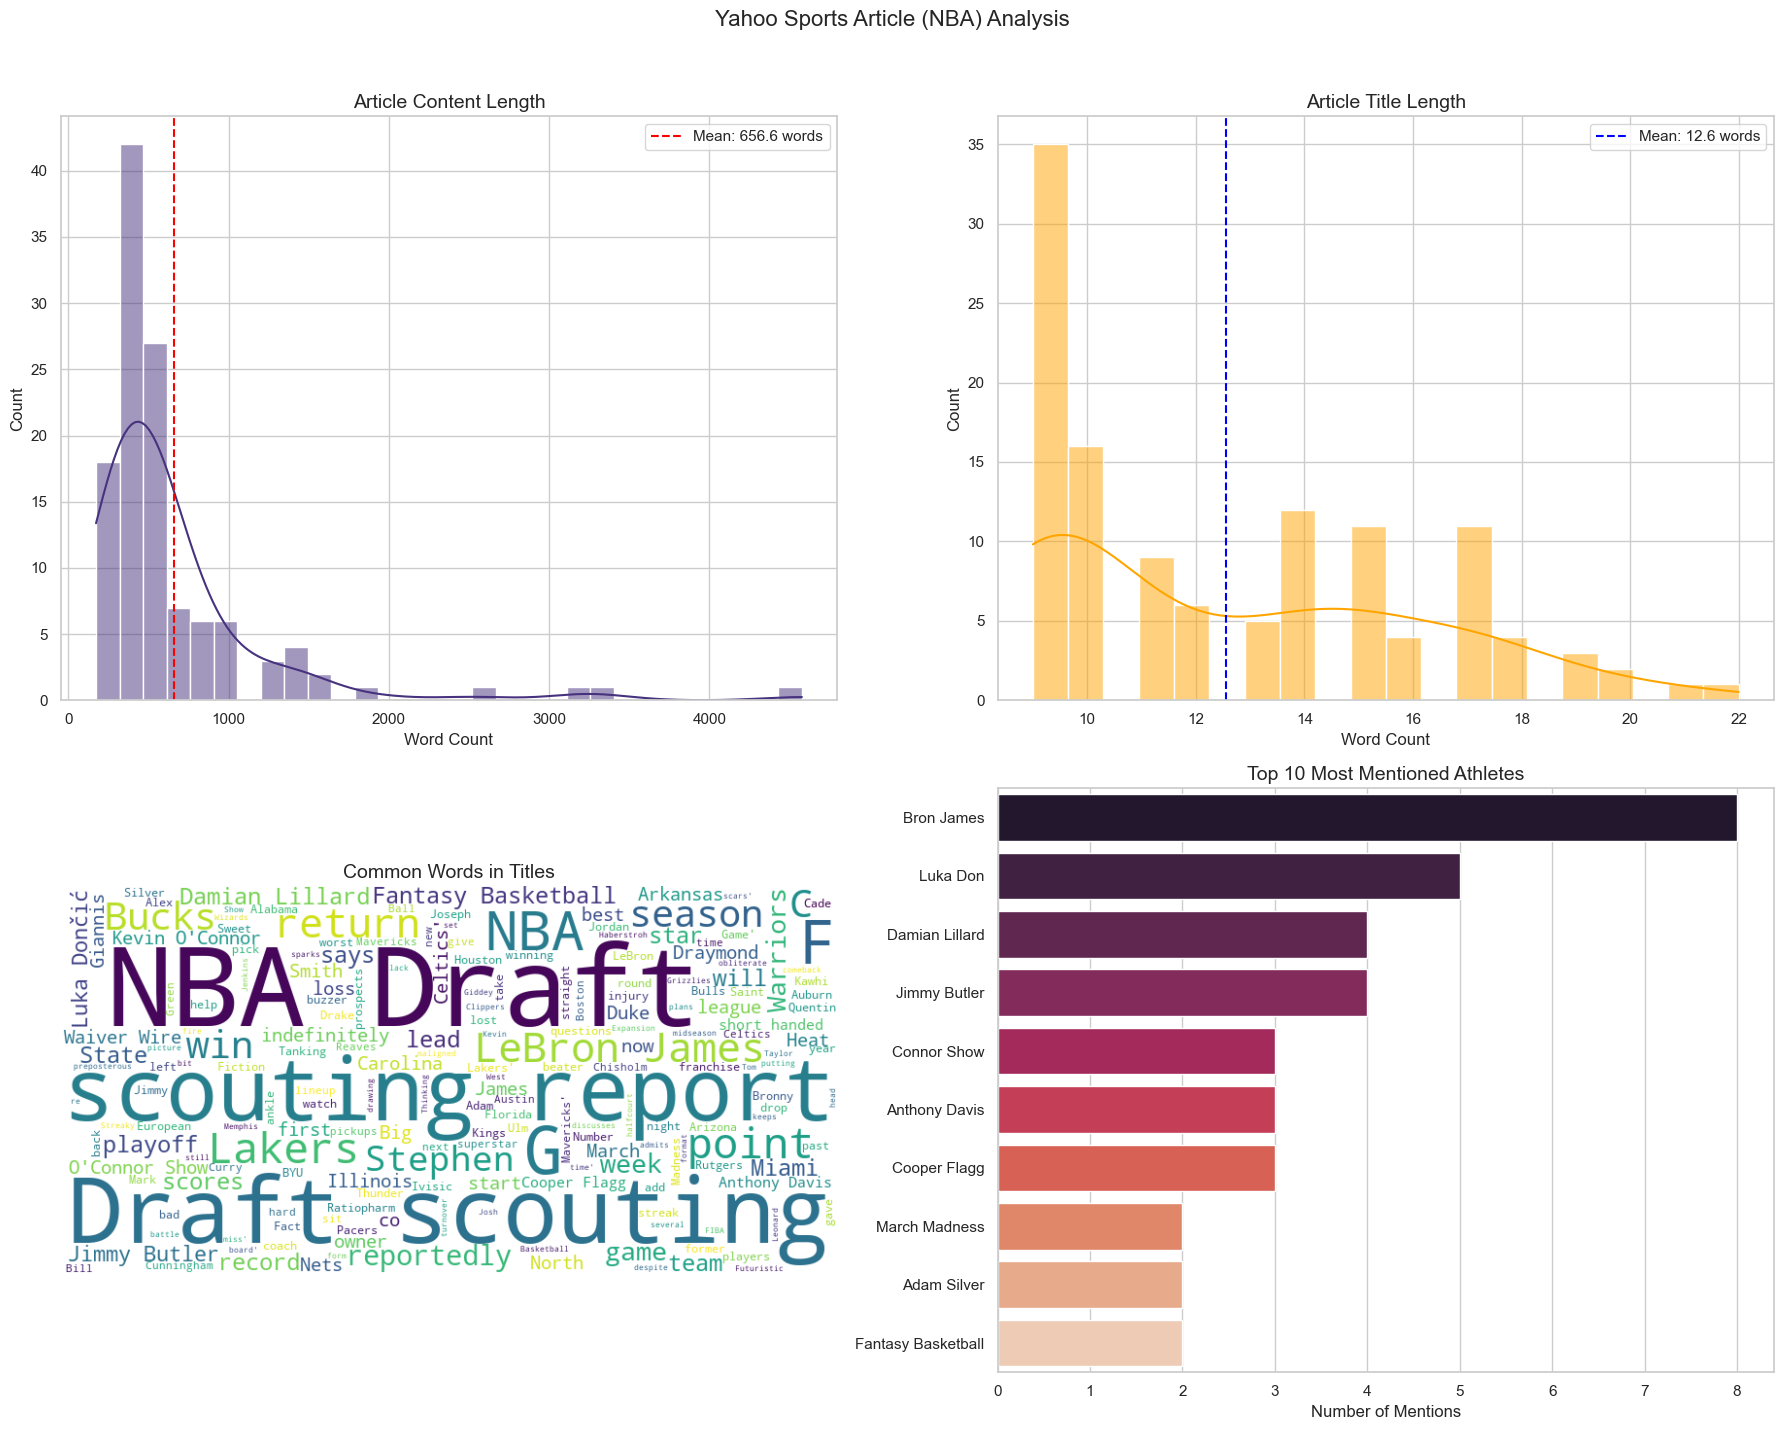

In [45]:
df = load_cleaned_data("cleaned_articles.json")
generate_visualizations(df)

# Prepare  The Dataset

In [7]:
import json
import os
import pandas as pd

# Create a data directory 
os.makedirs("data", exist_ok=True)

with open('cleaned_articles.json', 'r', encoding='utf-8') as f:
    articles = json.load(f)

# Convert to a format suitable for document store
documents = []
for i, article in enumerate(articles):
    documents.append({
        "content": article["description"],
        "meta": {
            "title": article["title"],
            "category": article["category"],
            "url": article.get("source_url", ""),
            "id": str(i)
        }
    })

# Save the processed documents
with open("data/processed_articles.json", "w") as f:
    json.dump(documents, f)

print(f"Processed {len(documents)} articles")

Processed 120 articles


# Set Up the Document Store

In [ ]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack import Document
import json
# Initialize document store without optional parameters
document_store = InMemoryDocumentStore()

# Loading the  documents
with open("data/processed_articles.json", "r") as f:
    raw_documents = json.load(f)

# Create Document objects with minimal parameters
docs = []
for i, doc in enumerate(raw_documents):
    # Extract the necessary fields
    content = doc.get('content', '')
    meta = doc.get('meta', {})
    
    # Create document with minimal parameters
    document = Document(
        content=content,
        meta=meta
    )
    docs.append(document)

print(f"Created {len(docs)} documents")


try:
    # Simple write attempt
    document_store.write_documents(documents=docs)
    
    # Check document count using the correct method for Haystack 2.x
    # Try different methods to get the count
    try:
        count = len(document_store.get_all_documents())
        print(f"Successfully wrote {count} documents")
    except:
        try:
            # Alternative method
            count = document_store.count_documents()
            print(f"Successfully wrote {count} documents")
        except:
            print("Documents were written, but couldn't determine count")
            
except Exception as e:
    print(f"Error: {e}")

Created 120 documents
Successfully wrote 120 documents


# Create the Retriever Component

In [2]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

# Initialize the retriever
retriever = InMemoryBM25Retriever(document_store=document_store)

# Run the query
result = retriever.run(query="What happened between LeBron James and Stephen A. Smith?")


print("Raw result structure:")
print(result)

# Access and print the documents
if 'documents' in result:
    retrieved_docs = result['documents']
    print(f"\nRetrieved {len(retrieved_docs)} documents:")
    
    for i, doc in enumerate(retrieved_docs):
        print(f"\nDocument {i+1}:")
        print(f"Content: {doc.content[:200]}...") 
        print(f"Score: {doc.score:.4f}")
        print("Metadata:")
        for key, value in doc.meta.items():
            print(f"  {key}: {value}")
else:
    print("No documents were retrieved")

Raw result structure:
{'documents': [Document(id=0, content: 'LeBron James lost his battle with Stephen A. Smith from the very start LeBron James is one of the gr...', meta: {'title': 'LeBron James lost his battle with Stephen A. Smith from the very start', 'category': 'NBA', 'url': 'https://ca.sports.yahoo.com/news/lebron-james-lost-his-battle-with-stephen-a-smith-from-the-very-start-175229782.html'}, score: 21.66976539926962), Document(id=15, content: 'Stephen A. Smith says he would have 'immediately' taken swing at LeBron James had Lakers star touche...', meta: {'title': "Stephen A. Smith says he would have 'immediately' taken swing at LeBron James had Lakers star touched him in confrontation", 'category': 'NBA', 'url': 'https://ca.sports.yahoo.com/news/stephen-a-smith-says-he-would-have-immediately-taken-swing-at-lebron-james-had-lakers-star-touched-him-in-confrontation-043947098.html'}, score: 21.30565437793397), Document(id=24, content: 'LeBron James talks relationship with Micha

In [ ]:
from haystack.components.readers import ExtractiveReader
from haystack import Document, Pipeline

#Initialize Reader (BERT/DistilBERT/RoBERTa)
reader = ExtractiveReader(model="deepset/roberta-base-squad2")

#Build Retriever-Reader Pipeline
qa_pipeline = Pipeline()
qa_pipeline.add_component("retriever", retriever)
qa_pipeline.add_component("reader", reader)
qa_pipeline.connect("retriever", "reader")






c:\Users\sales\anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def print_answers(result, top_k=3, min_confidence=0.5):
    answers = result.get("reader", {}).get("answers", [])

    # Filter out low-confidence answers
    filtered = [a for a in answers if a.score >= min_confidence]

    if not filtered:
        print(" Sorry, I couldn’t find any answer related to that topic in my knowledge base.")
        return

    for i, ans in enumerate(filtered[:top_k]):
        answer_text = ans.data or "[No answer text]"
        print(f"\n Answer {i+1}: {answer_text} (Confidence: {ans.score:.4f})")
        
        if ans.document and ans.document.meta:
            title = ans.document.meta.get("title", "N/A")
            url = ans.document.meta.get("url", "N/A")
            print(f"Source Title: {title}")
            print(f"URL: {url}")


In [5]:
questions = [
    "Why did Stephen A. Smith criticize LeBron James?",
    "Who did the Lakers defeat in the NBA Finals?",
    "What did LeBron say on Pat McAfee's show?",
]

for q in questions:
    print(f"\n---\nQuestion: {q}")
    result = qa_pipeline.run({
        "retriever": {"query": q},
        "reader": {"query": q}
    })
    print_answers(result)



---
Question: Why did Stephen A. Smith criticize LeBron James?

 Answer 1: Smith's coverage of James' son Bronny (Confidence: 0.7161)
Source Title: Stephen A. Smith says he would have 'immediately' taken swing at LeBron James had Lakers star touched him in confrontation
URL: https://ca.sports.yahoo.com/news/stephen-a-smith-says-he-would-have-immediately-taken-swing-at-lebron-james-had-lakers-star-touched-him-in-confrontation-043947098.html

 Answer 2: criticizing James family (Confidence: 0.6858)
Source Title: LeBron James lost his battle with Stephen A. Smith from the very start
URL: https://ca.sports.yahoo.com/news/lebron-james-lost-his-battle-with-stephen-a-smith-from-the-very-start-175229782.html

 Answer 3: lying about his coverage of Bronny (Confidence: 0.6612)
Source Title: Stephen A. Smith says he would have 'immediately' taken swing at LeBron James had Lakers star touched him in confrontation
URL: https://ca.sports.yahoo.com/news/stephen-a-smith-says-he-would-have-immediately

In [9]:
questions = [
    "what is your name ",
    "what is your age",
    "who is the president of the united states",
    "what is the capital of France",
    "what is the largest mammal",
 
]

for q in questions:
    print(f"\n---\nQuestion: {q}")
    result = qa_pipeline.run({
        "retriever": {"query": q},
        "reader": {"query": q}
    })
    print_answers(result,3,0.7)


---
Question: what is your name 
 Sorry, I couldn’t find any answer related to that topic in my knowledge base.

---
Question: what is your age

 Answer 1: 57 (Confidence: 0.7114)
Source Title: LaVar Ball says he's 'hard to kill,' recounts foot amputation, health scare, sons' success
URL: https://ca.sports.yahoo.com/news/lavar-ball-says-hes-hard-to-kill-recounts-foot-amputation-health-scare-sons-success-203354484.html

---
Question: who is the president of the united states
 Sorry, I couldn’t find any answer related to that topic in my knowledge base.

---
Question: what is the capital of France
 Sorry, I couldn’t find any answer related to that topic in my knowledge base.

---
Question: what is the largest mammal
 Sorry, I couldn’t find any answer related to that topic in my knowledge base.


In [ ]:
# Fetch all documents using filter_documents() with no filters
docs = document_store.filter_documents()

# Now convert each document to a dict for JSON serializable
import json

json_docs = [doc.to_dict() for doc in docs]

# Save to file
with open("models/documents.json", "w", encoding="utf-8") as f:
    json.dump(json_docs, f, indent=2)

print(f" Saved {len(json_docs)} documents to models/documents.json")


 Saved 120 documents to models/documents.json


# Evaluation

Load Saved Pipeline Components for Evaluation

In [ ]:

import json
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.readers import ExtractiveReader
from haystack import Pipeline, Document


# Load the Saved Documents

def load_documents_from_file(path="models/documents.json"):
    with open(path, "r", encoding="utf-8") as f:
        doc_dicts = json.load(f)
    return [Document.from_dict(d) for d in doc_dicts]

# Build Pipeline from Components


def build_evaluation_pipeline(documents):
    # Create document store and insert documents
    document_store = InMemoryDocumentStore()
    document_store.write_documents(documents)

    # Create retriever and reader
    retriever = InMemoryBM25Retriever(document_store=document_store)
    reader = ExtractiveReader(model="deepset/roberta-base-squad2")

    # Build pipeline
    pipe = Pipeline()
    pipe.add_component("retriever", retriever)
    pipe.add_component("reader", reader)
    pipe.connect("retriever", "reader")

    return pipe


# Initialize Everything

documents = load_documents_from_file()
qa_pipeline = build_evaluation_pipeline(documents)
print(f"Loaded {len(documents)} documents into the pipeline.")


c:\Users\sales\anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 120 documents into the pipeline.


In [16]:
eval_questions = [
    "Which two individuals announced the NBA's exploration of a European league?",
    "Which team did the Thunder sweep in the first round last year?",
    "Who scored the go-ahead basket for the Lakers before Giddey's final shot?",
    "Before Memphis, which two NBA teams did Jenkins serve as an assistant coach for?",
    "What happened between LeBron James and Stephen A. Smith?",
    "For what team Steph curry plays for?",
    "Who is out indefinitely for the Bucks?",
    "Which player returned to Miami?",
    "How many teams is the proposed European league planned to have, and how many would be permanent?",
    "What did the Pacers do in the final two minutes of the game instead of trying to score more?"
]


In [17]:
results = []
for q in eval_questions:
    res = qa_pipeline.run({
        "retriever": {"query": q, "top_k": 5},
        "reader": {"query": q, "top_k": 3}
    })
    answer = res["reader"]["answers"][0].data if res["reader"]["answers"] else "N/A"
    score = res["reader"]["answers"][0].score if res["reader"]["answers"] else 0
    results.append({"question": q, "answer": answer, "confidence": score})


In [18]:
import pandas as pd

df = pd.DataFrame(results)
display(df)



,question,answer,confidence
0,Which two individuals announced the NBA's expl...,Scott Soshnick and Eben Novy-Williams,0.820439
1,Which team did the Thunder sweep in the first ...,New Orleans Pelicans,0.814227
2,Who scored the go-ahead basket for the Lakers ...,Austin Reaves,0.762242
3,"Before Memphis, which two NBA teams did Jenkin...",Milwaukee Bucks and five years as an assistant...,0.751989
4,What happened between LeBron James and Stephen...,verbal confrontation,0.667070
5,For what team Steph curry plays for?,Golden State,0.722121
6,Who is out indefinitely for the Bucks?,Damian Lillard,0.816893
7,Which player returned to Miami?,Jimmy,0.738451
8,How many teams is the proposed European league...,12,0.801344
9,What did the Pacers do in the final two minute...,took three straight shot-clock violations,0.776990


In [19]:
# Manually add correctness annotations (1 = correct, 0.5 = partially correct, 0 = incorrect)
df["correctness"] = [0, 1, 1, 1, 1, 1, 1, 0.5, 0.5, 1]

# Calculate average accuracy score
avg_score = df["correctness"].mean()

# Display full DataFrame and accuracy
display(df)
print(f"\nAverage Accuracy Score: {avg_score:.2f}")

,question,answer,confidence,correctness
0,Which two individuals announced the NBA's expl...,Scott Soshnick and Eben Novy-Williams,0.820439,0.0
1,Which team did the Thunder sweep in the first ...,New Orleans Pelicans,0.814227,1.0
2,Who scored the go-ahead basket for the Lakers ...,Austin Reaves,0.762242,1.0
3,"Before Memphis, which two NBA teams did Jenkin...",Milwaukee Bucks and five years as an assistant...,0.751989,1.0
4,What happened between LeBron James and Stephen...,verbal confrontation,0.667070,1.0
5,For what team Steph curry plays for?,Golden State,0.722121,1.0
6,Who is out indefinitely for the Bucks?,Damian Lillard,0.816893,1.0
7,Which player returned to Miami?,Jimmy,0.738451,0.5
8,How many teams is the proposed European league...,12,0.801344,0.5
9,What did the Pacers do in the final two minute...,took three straight shot-clock violations,0.776990,1.0



Average Accuracy Score: 0.80
